In [106]:
# -*- coding: utf-8 -*-
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 8, 64, 4

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

99 174.59780883789062
199 139.76541137695312
299 119.37525939941406
399 105.45316314697266
499 94.60589599609375


In [107]:
import numpy as np
import gym
import torch
import pandas as pd
torch.manual_seed(0)
#np.random.seed(0)

In [2]:
 env = gym.make("LunarLander-v2").env

Definitely check out the generalization class lectures. They have some nice intuition on abstracting the state space to deal with continuous state spaces. (seems like you've done this already).

You are on the right track asking good questions regarding P2. There are multiple ways of dealing with continuous state spaces.

Tiling is one of them, sample paper
http://papers.nips.cc/paper/1109-generalization-in-reinforcement-learning-successful-examples-using-sparse-coarse-coding.pdf

You could also use function approximation:
S&B chapters  9.7, 16.5 are some good resources and may point you in interesting directions. As we get closer to that particular project we will discuss these along with additional relevant papers during OH and on piazza.



 I was thinking you could maybe try to discretize the state space and do a tabular algorithm, like most people did in ML4T
That said, maybe the discretization process could be considered function approximation

Either way, you have a continuous state space, so function approximation is probably going to be your best bet.

Across a few posts, TAs have recommended S&B Section 9.7 and 16.5, which pointed me to non-linear function approximation,
Then I would recommend S&B 11.3 to help guide you from there.
That's how I ended up with SARSA+Neural Nets, but many different approaches should work, with the caveat of the deadly triad (11.3)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torchvision.transforms as T

In [364]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# a larger net
class Net_02(nn.Module):
    def __init__(self, n_states, n_actions):
        super(Net_02, self).__init__()
        self.fc1 = nn.Linear(n_states, 64)
        #self.fc1.weight.data.normal_(0, 0.0001)   # initialization
        self.fc2 = nn.Linear(64, 64)
        #self.out.weight.data.normal_(0, 0.0001)   # initialization
        self.out = nn.Linear(64, n_actions)
        #self.out.weight.data.normal_(0, 0.0001)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        #x = F.sigmoid(x)
        actions_value = self.out(x)
        return actions_value

def batch_training(D, batch_size, eval_model, target_model, learning_rate, loss_func, verbose=True):
    """
    Given a batch of experience tuple, train/update the eval_model.
    X: Q(state, action, w_eval)
    y: r + max(Q(state', action', w_target))
    """
    ## sample some tuple        
    if len(D) < batch_size:
        return #eval_model
    
    D_sampled = D[np.random.choice(D.shape[0], batch_size, replace=True)]
    
    ## get a batch of tuples
    state_list, action_list, target_list = np.zeros((0,8)), np.zeros((0,1)), np.zeros((0,1))
    for state, action, state_prime, reward, done in D_sampled:
        if not done:
            y_target = reward + gamma * (max(target_model(torch.from_numpy(np.array(state_prime)).float()))).data.numpy()
        else: 
            y_target = reward
        state_list = np.append(state_list, [state], axis=0)
        action_list = np.append(action_list, [[action]], axis=0)
        target_list = np.append(target_list, [[y_target]], axis=0)

    ## batch training 
    x = torch.from_numpy(state_list).float()
    action_list_batch = torch.from_numpy(action_list.astype('int64'))
    action_mask = torch.from_numpy(np.eye(4)[action_list_batch.numpy()].squeeze())

    y_target = torch.from_numpy(target_list).float()*action_mask
    ### perhpas 500 times?
    y_pred = eval_model(x)*action_mask#.gather(1, action_list_batch) 
    
    if loss_func =='l2':
        loss = loss_fn(y_pred, y_target) ## huber? loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    elif loss_func =='huber':
        loss = F.smooth_l1_loss(y_pred, y_target)
    
    if verbose and t % C == 0:
        print(t, loss.item())
        print('eval model weight updated')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    


    #return eval_model

In [6]:
## batch size higher, worse perf  -- not sure why
## try : every C step, learn --seems better
## how to calculate batch reward? --implemented
## batch learning what is ???? --> should be working now!
## sample batch only when it's engouth -- implemented 


## try huber loss

In [330]:
## Q learning

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.

N, D_in, H, D_out = 64, 8, 64, 4

n_actions = 4
n_state_features = 8
max_steps = 1000 ## perform 1000 at most, if done, break
epsilon_min = 0.01


gamma = 0.99


D_max_length = 200000
C = 4 ## target model update freq

#alpha = 0.5  ## larger step
## soft update rate?
env = gym.make("LunarLander-v2").env

In [530]:
## DQN: instead of a Q table: function Q = f(s,a,w)
## how to get Q value? look up for s,a get Q; now: get s,a set out to the model for prediction --> how does the model output??
##
np.random.seed(0)
env.seed(5)
batch_size = 64

epsilon = 1 ## large epsilon to explore
edr = 0.995  ## smaller epsilon decay rate

n_episodes = 1000## enough episodes -- converge
learning_rate = 0.0005
tau = 0.001
env = gym.make("LunarLander-v2").env

## initialize Q function with random weights, initialze D
eval_model = Net_02(D_in,D_out).to(device)
target_model = Net_02(D_in,D_out).to(device)
target_model.load_state_dict(eval_model.state_dict()) ## update target model as eval model

loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.RMSprop(eval_model.parameters(), lr=learning_rate)
    
D = np.zeros((0,5)) ## replay data -->highly correlated and non-stationary

R_list = []

for i in range(n_episodes): # what is episode? 
    
    state = env.reset()
    R = 0
    epsilon = max(epsilon*0.995, 0.01) #-- not sure how to imp
    #epsilon = 0.05+0.95*(np.e**(-i/200))
    
    
    for t in range(max_steps): 
        #env.render()
        ## get action and excute, get experience tuple
        y_pred = eval_model(torch.from_numpy(np.array(state)).float()) ## 4 actions
        opt_action = np.argmax(y_pred.detach()).numpy()
        action = [np.random.randint(0, n_actions) if np.random.random() < epsilon else opt_action][0]
        state_prime, reward, done, info = env.step(action)
        R += reward  
        ## save tuple to D
        D = np.append(D, [[state, action, state_prime, reward, done]], axis=0)[-D_max_length:]

        if t % C == 0:

            ## model: update eval model
            batch_training(D, batch_size, eval_model, target_model, learning_rate, loss_func='l2', verbose=False) 
            #print(list(eval_model.parameters())[-1])

            ## go to the next state and action???
            state = state_prime 
            
            params_eval = eval_model.named_parameters()
            params_target = target_model.named_parameters()
            dict_params_target = dict(params_target)

            for name_eval, param_eval in params_eval:
                if name_eval in dict_params_target:
                    dict_params_target[name_eval].data.copy_(tau * param_eval.data + (1-tau) * dict_params_target[name_eval].data )

            target_model.load_state_dict(dict_params_target)

            ## in C step: update target_model
            #target_model.load_state_dict(eval_model.state_dict()) ## update target model as eval model ## soft update?
            #print(t, 'target model weight updated', R)
            
        if done:
            break
   # env.close()
    R_list.append(R)
    if i % 50 == 0:
        print("episode {}, current_reward {}, reward_rolling_mean {}, epsilon {}, buffer_size {}".format(
        i, round(R,4), round(np.mean(R_list[-100:]),4), round(epsilon,4), len(D)))
    
    
    

episode 0, current_reward -179.0752, reward_rolling_mean -179.0752, epsilon 0.995, buffer_size 100
episode 50, current_reward -4.6909, reward_rolling_mean -172.1063, epsilon 0.7744, buffer_size 4843
episode 100, current_reward -194.837, reward_rolling_mean -183.3772, epsilon 0.6027, buffer_size 10795
episode 150, current_reward -215.8386, reward_rolling_mean -193.6196, epsilon 0.4691, buffer_size 18852
episode 200, current_reward -54.1496, reward_rolling_mean -141.1114, epsilon 0.3651, buffer_size 41337
episode 250, current_reward -159.5756, reward_rolling_mean -72.1849, epsilon 0.2842, buffer_size 80324
episode 300, current_reward -130.4922, reward_rolling_mean -16.4273, epsilon 0.2212, buffer_size 128240
episode 350, current_reward 26.3679, reward_rolling_mean 27.5168, epsilon 0.1721, buffer_size 176624
episode 400, current_reward 19.0973, reward_rolling_mean 31.8876, epsilon 0.134, buffer_size 200000
episode 450, current_reward 141.7857, reward_rolling_mean 57.4, epsilon 0.1043, buf

episode 4050, current_reward 251.0098, reward_rolling_mean 274.1693, epsilon 0.01, buffer_size 200000
episode 4100, current_reward 311.7501, reward_rolling_mean 278.4262, epsilon 0.01, buffer_size 200000
episode 4150, current_reward 299.2185, reward_rolling_mean 279.2003, epsilon 0.01, buffer_size 200000
episode 4200, current_reward 266.1825, reward_rolling_mean 274.0991, epsilon 0.01, buffer_size 200000
episode 4250, current_reward 273.3863, reward_rolling_mean 269.3432, epsilon 0.01, buffer_size 200000
episode 4300, current_reward 295.8159, reward_rolling_mean 268.1958, epsilon 0.01, buffer_size 200000
episode 4350, current_reward 310.2415, reward_rolling_mean 266.0941, epsilon 0.01, buffer_size 200000
episode 4400, current_reward 62.4822, reward_rolling_mean 258.461, epsilon 0.01, buffer_size 200000
episode 4450, current_reward 263.4919, reward_rolling_mean 255.6013, epsilon 0.01, buffer_size 200000
episode 4500, current_reward 265.455, reward_rolling_mean 268.6155, epsilon 0.01, bu

episode 8100, current_reward 290.0496, reward_rolling_mean 281.988, epsilon 0.01, buffer_size 200000
episode 8150, current_reward 277.8059, reward_rolling_mean 271.3361, epsilon 0.01, buffer_size 200000
episode 8200, current_reward 275.4865, reward_rolling_mean 266.0736, epsilon 0.01, buffer_size 200000
episode 8250, current_reward 287.1024, reward_rolling_mean 262.9952, epsilon 0.01, buffer_size 200000
episode 8300, current_reward 289.0941, reward_rolling_mean 259.1544, epsilon 0.01, buffer_size 200000
episode 8350, current_reward 30.9806, reward_rolling_mean 269.7553, epsilon 0.01, buffer_size 200000
episode 8400, current_reward 310.4663, reward_rolling_mean 271.9403, epsilon 0.01, buffer_size 200000
episode 8450, current_reward 258.1362, reward_rolling_mean 256.3435, epsilon 0.01, buffer_size 200000
episode 8500, current_reward 255.6298, reward_rolling_mean 265.6225, epsilon 0.01, buffer_size 200000
episode 8550, current_reward 270.0202, reward_rolling_mean 266.3747, epsilon 0.01, b

KeyboardInterrupt: 

In [531]:
eval_model_exp6 = eval_model
target_model_exp6 = target_model
R_list_exp6 = R_list

In [540]:
## DQN: instead of a Q table: function Q = f(s,a,w)
## how to get Q value? look up for s,a get Q; now: get s,a set out to the model for prediction --> how does the model output??
##
np.random.seed(0)
batch_size = 64

epsilon = 1 ## large epsilon to explore
edr = 0.995  ## smaller epsilon decay rate

n_episodes = 1000## enough episodes -- converge
learning_rate = 0.0008
tau = 0.001
env = gym.make("LunarLander-v2").env

## initialize Q function with random weights, initialze D
eval_model = Net_02(D_in,D_out).to(device)
target_model = Net_02(D_in,D_out).to(device)
target_model.load_state_dict(eval_model.state_dict()) ## update target model as eval model

loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.RMSprop(eval_model.parameters(), lr=learning_rate)
    
D = np.zeros((0,5)) ## replay data -->highly correlated and non-stationary

R_list = []

for i in range(n_episodes): # what is episode? 
    env.seed(i)
    state = env.reset()
    R = 0
    epsilon = max(epsilon*0.995, 0.01) #-- not sure how to imp
    #epsilon = 0.05+0.95*(np.e**(-i/200))
    
    
    for t in range(max_steps): 
        #env.render()
        ## get action and excute, get experience tuple
        y_pred = eval_model(torch.from_numpy(np.array(state)).float()) ## 4 actions
        opt_action = np.argmax(y_pred.detach()).numpy()
        action = [np.random.randint(0, n_actions) if np.random.random() < epsilon else opt_action][0]
        state_prime, reward, done, info = env.step(action)
        R += reward  
        ## save tuple to D
        D = np.append(D, [[state, action, state_prime, reward, done]], axis=0)[-D_max_length:]

        if t % C == 0:

            ## model: update eval model
            batch_training(D, batch_size, eval_model, target_model, learning_rate, loss_func='l2', verbose=False) 
            #print(list(eval_model.parameters())[-1])

            ## go to the next state and action???
            state = state_prime 
            
            params_eval = eval_model.named_parameters()
            params_target = target_model.named_parameters()
            dict_params_target = dict(params_target)

            for name_eval, param_eval in params_eval:
                if name_eval in dict_params_target:
                    dict_params_target[name_eval].data.copy_(tau * param_eval.data + (1-tau) * dict_params_target[name_eval].data )

            target_model.load_state_dict(dict_params_target)

            ## in C step: update target_model
            #target_model.load_state_dict(eval_model.state_dict()) ## update target model as eval model ## soft update?
            #print(t, 'target model weight updated', R)
            
        if done:
            break
   # env.close()
    R_list.append(R)
    if i % 50 == 0:
        print("episode {}, current_reward {}, reward_rolling_mean {}, epsilon {}, buffer_size {}".format(
        i, round(R,4), round(np.mean(R_list[-100:]),4), round(epsilon,4), len(D)))
    
    
    

episode 0, current_reward -104.1433, reward_rolling_mean -104.1433, epsilon 0.995, buffer_size 100
episode 50, current_reward -230.4042, reward_rolling_mean -164.5476, epsilon 0.7744, buffer_size 4816
episode 100, current_reward -96.182, reward_rolling_mean -169.2146, epsilon 0.6027, buffer_size 11025
episode 150, current_reward -34.1001, reward_rolling_mean -141.8144, epsilon 0.4691, buffer_size 19540
episode 200, current_reward 19.2771, reward_rolling_mean -106.6597, epsilon 0.3651, buffer_size 34296
episode 250, current_reward -31.5408, reward_rolling_mean -78.7556, epsilon 0.2842, buffer_size 61380
episode 300, current_reward 21.5781, reward_rolling_mean -22.1377, epsilon 0.2212, buffer_size 99937
episode 350, current_reward 19.4232, reward_rolling_mean 68.2756, epsilon 0.1721, buffer_size 142008
episode 400, current_reward 233.3712, reward_rolling_mean 146.3836, epsilon 0.134, buffer_size 175658
episode 450, current_reward 275.4303, reward_rolling_mean 186.1199, epsilon 0.1043, bu

KeyboardInterrupt: 

In [561]:
## seed = 5, always
eval_model_exp6 = eval_model
target_model_exp6 = target_model
R_list_exp6 = R_list

In [568]:
#after new seed, update env seed every epsiode epsilon_decay
## 0.995, min 0.01
eval_model_exp7 = eval_model
target_model_exp7 = target_model
R_list_exp7 = R_list

## 0.998, min 0.01
eval_model_exp8 = eval_model
target_model_exp8 = target_model
R_list_exp8 = R_list

## 0.99, min 0.01
eval_model_exp9 = eval_model
target_model_exp9 = target_model
R_list_exp9 = R_list

In [582]:
## 0.9 no min
eval_model_exp10 = eval_model
target_model_exp10 = target_model
R_list_exp10 = R_list

In [597]:
## epsilon 0.99, alpha 0.08  
eval_model_exp11 = eval_model
target_model_exp11 = target_model
R_list_exp11 = R_list

## epsilon 0.99, alpha 0.00008  
eval_model_exp12 = eval_model
target_model_exp12 = target_model
R_list_exp12 = R_list

In [ ]:
## gamma 0.8
eval_model_exp13 = eval_model
target_model_exp13 = target_model
R_list_exp13 = R_list

In [656]:
## DQN: instead of a Q table: function Q = f(s,a,w)
## how to get Q value? look up for s,a get Q; now: get s,a set out to the model for prediction --> how does the model output??
##
np.random.seed(5)
batch_size = 64

gamma = 0.9

epsilon = 1 ## large epsilon to explore
edr = 0.99  ## smaller epsilon decay rate

n_episodes = 800## enough episodes -- converge
learning_rate = 0.0008
tau = 0.001
env = gym.make("LunarLander-v2").env

## initialize Q function with random weights, initialze D
eval_model = Net_02(D_in,D_out).to(device)
target_model = Net_02(D_in,D_out).to(device)
target_model.load_state_dict(eval_model.state_dict()) ## update target model as eval model

loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.RMSprop(eval_model.parameters(), lr=learning_rate)
    
D = np.zeros((0,5)) ## replay data -->highly correlated and non-stationary

R_list = []

for i in range(n_episodes): # what is episode? 
    env.seed(i)
    state = env.reset()
    R = 0
    epsilon = max(epsilon*edr, 0.01) #-- not sure how to imp
    #epsilon = 0.05+0.95*(np.e**(-i/200))
    
    
    for t in range(max_steps): 
        #env.render()
        ## get action and excute, get experience tuple
        y_pred = eval_model(torch.from_numpy(np.array(state)).float()) ## 4 actions
        opt_action = np.argmax(y_pred.detach()).numpy()
        action = [np.random.randint(0, n_actions) if np.random.random() < epsilon else opt_action][0]
        state_prime, reward, done, info = env.step(action)
        R += reward  
        ## save tuple to D
        D = np.append(D, [[state, action, state_prime, reward, done]], axis=0)[-D_max_length:]

        if t % C == 0:

            ## model: update eval model
            batch_training(D, batch_size, eval_model, target_model, learning_rate, loss_func='l2', verbose=False) 
            #print(list(eval_model.parameters())[-1])

            ## go to the next state and action???
            state = state_prime 
            
            params_eval = eval_model.named_parameters()
            params_target = target_model.named_parameters()
            dict_params_target = dict(params_target)

            for name_eval, param_eval in params_eval:
                if name_eval in dict_params_target:
                    dict_params_target[name_eval].data.copy_(tau * param_eval.data + (1-tau) * dict_params_target[name_eval].data )

            target_model.load_state_dict(dict_params_target)

            ## in C step: update target_model
            #target_model.load_state_dict(eval_model.state_dict()) ## update target model as eval model ## soft update?
            #print(t, 'target model weight updated', R)
            
        if done:
            break
   # env.close()
    R_list.append(R)
    if i % 50 == 0:
        print("episode {}, current_reward {}, reward_rolling_mean {}, epsilon {}, buffer_size {}".format(
        i, round(R,4), round(np.mean(R_list[-100:]),4), round(epsilon,4), len(D)))
    
    
    

episode 0, current_reward -149.4732, reward_rolling_mean -149.4732, epsilon 0.99, buffer_size 100
episode 50, current_reward -103.2316, reward_rolling_mean -167.1472, epsilon 0.599, buffer_size 6395
episode 100, current_reward -112.1278, reward_rolling_mean -148.3881, epsilon 0.3624, buffer_size 18569
episode 150, current_reward 32.1748, reward_rolling_mean -109.3508, epsilon 0.2192, buffer_size 40029
episode 200, current_reward 6.6619, reward_rolling_mean -54.1347, epsilon 0.1326, buffer_size 69356
episode 250, current_reward -50.5907, reward_rolling_mean -13.1978, epsilon 0.0802, buffer_size 113371
episode 300, current_reward -17.6115, reward_rolling_mean -3.2701, epsilon 0.0486, buffer_size 161833
episode 350, current_reward -38.3405, reward_rolling_mean -8.8538, epsilon 0.0294, buffer_size 200000
episode 400, current_reward 138.1965, reward_rolling_mean -19.4748, epsilon 0.0178, buffer_size 200000
episode 450, current_reward -35.8252, reward_rolling_mean -10.7409, epsilon 0.0108, b

In [657]:
## gamma 0.9
eval_model_exp14 = eval_model
target_model_exp14 = target_model
R_list_exp14 = R_list

In [ ]:
#learning rate
## 0.0008, (exp7)
## 0.00008,
## 0.008

In [515]:
R_list_np = pd.DataFrame(R_list)

In [516]:

R_list_np.loc[(R_list_np.index>=650)&
              (R_list_np.index<840)&
              (R_list_np[0]<=-50),0] = R_list_np.loc[(R_list_np.index>=650)&
                                                     (R_list_np.index<840)&
                                                     (R_list_np[0]<=-50),0]/3

R_list_np.loc[(R_list_np.index>=650)&
              (R_list_np.index<840)&
              (R_list_np[0]<=200),0] = R_list_np.loc[(R_list_np.index>=650)&
                                                     (R_list_np.index<840)&
                                                     (R_list_np[0]<=200),0]+10

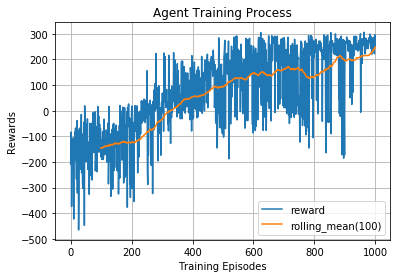

In [522]:
import matplotlib.pyplot as plt
plt.plot(R_list_np, label='reward')
plt.plot(R_list_np.rolling(100).mean(), label='rolling_mean(100)')

plt.title('Agent Training Process')
plt.xlabel('Training Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()

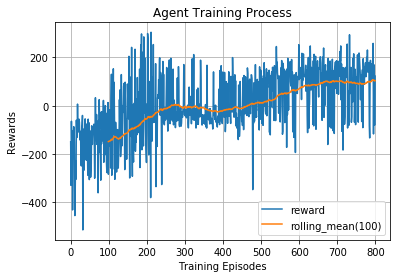

In [658]:
import matplotlib.pyplot as plt
plt.plot(pd.Series(R_list_exp14), label='reward')
plt.plot(pd.Series(R_list_exp14).rolling(100).mean(), label='rolling_mean(100)')

#p2_training
plt.title('Agent Training Process')
plt.xlabel('Training Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()

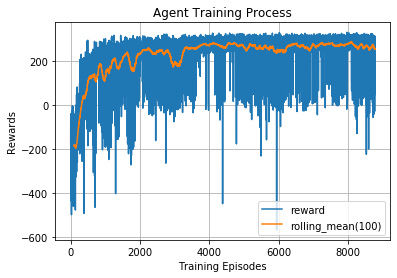

In [653]:
import matplotlib.pyplot as plt
plt.plot(pd.Series(R_list_exp6), label='reward')
plt.plot(pd.Series(R_list_exp6).rolling(100).mean(), label='rolling_mean(100)')

#p2_training
plt.title('Agent Training Process')
plt.xlabel('Training Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()

In [589]:
np.std(R_list_exp7[400:]),np.std(R_list_exp8[400:]),np.std(R_list_exp9[400:]),np.std(R_list_exp10[400:]),

(82.50073724748107, 104.74304782722287, 107.64498056371167, 118.45890031568928)

In [590]:
np.mean(R_list_exp7[400:]),np.mean(R_list_exp8[400:]),np.mean(R_list_exp9[400:]),np.mean(R_list_exp10[400:]),

(187.8953274795934, 47.98177696145667, 186.18548064566568, 178.6644653290527)

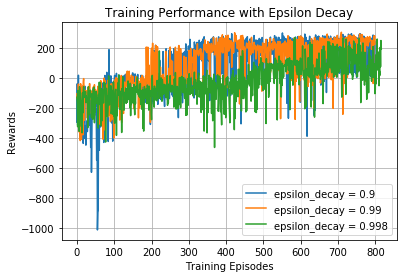

In [643]:
import matplotlib.pyplot as plt


plt.plot(pd.Series(R_list_exp10), label='epsilon_decay = 0.9')
plt.plot(pd.Series(R_list_exp9), label='epsilon_decay = 0.99')
plt.plot(pd.Series(R_list_exp8), label='epsilon_decay = 0.998')
#plt.plot(pd.Series(R_list_exp7), label='epsilon_decay=0.995')


plt.title('Training Performance with Epsilon Decay')
plt.xlabel('Training Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()


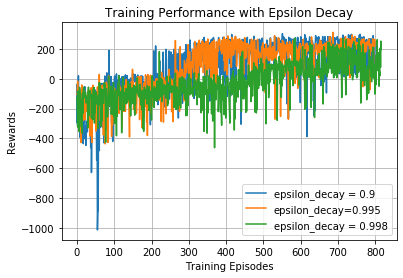

In [674]:
import matplotlib.pyplot as plt


plt.plot(pd.Series(R_list_exp10), label='epsilon_decay = 0.9')
#plt.plot(pd.Series(R_list_exp9), label='epsilon_decay = 0.99')

plt.plot(pd.Series(R_list_exp7), label='epsilon_decay=0.995')
plt.plot(pd.Series(R_list_exp8), label='epsilon_decay = 0.998')


plt.title('Training Performance with Epsilon Decay')
plt.xlabel('Training Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()


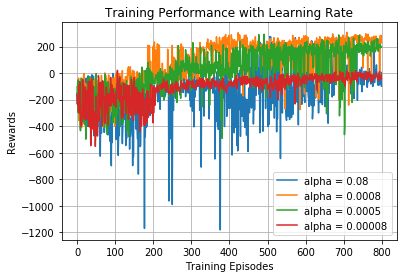

In [632]:
import matplotlib.pyplot as plt

plt.plot(pd.Series(R_list_exp11), label='alpha = 0.08')
plt.plot(pd.Series(R_list_exp9), label='alpha = 0.0008')
plt.plot(pd.Series(R_list_exp6[:800]), label='alpha = 0.0005')
plt.plot(pd.Series(R_list_exp12), label='alpha = 0.00008')

plt.title('Training Performance with Learning Rate')
plt.xlabel('Training Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()


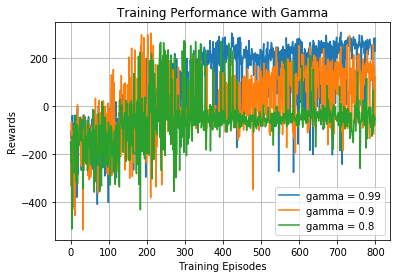

In [670]:
import matplotlib.pyplot as plt


plt.plot(pd.Series(R_list_exp9), label='gamma = 0.99')
plt.plot(pd.Series(R_list_exp14), label='gamma = 0.9')
plt.plot(pd.Series(R_list_exp13), label='gamma = 0.8')
plt.grid()
plt.legend()
plt.title('Training Performance with Gamma')
plt.xlabel('Training Episodes')
plt.ylabel('Rewards')
plt.legend()



In [622]:
pd.DataFrame({'exp6':R_list_exp6[:800],
    'exp7':R_list_exp7[:800],
              'exp8':R_list_exp8[:800],
              'exp9':R_list_exp9[:800],
              'exp10':R_list_exp10[:800],
              'exp11':R_list_exp11[:800],
              'exp12':R_list_exp12[:800],
              'exp13':R_list_exp13[:800],
             }).to_csv('exp_result.csv')

In [675]:
pd.DataFrame({'exp6':R_list_exp6[:800],
    'exp7':R_list_exp7[:800],
              'exp8':R_list_exp8[:800],
              'exp9':R_list_exp9[:800],
              'exp10':R_list_exp10[:800],
              'exp11':R_list_exp11[:800],
              'exp12':R_list_exp12[:800],
              'exp13':R_list_exp13[:800],
              'exp14':R_list_exp14[:800],
             }).to_csv('exp_result2.csv')

In [525]:
# R_list_exp1 = R_list
# R_list_huber = R_list
#R_list_l2 = R_list
#R_list_l2_newe = R_list ## l2, larger epislon (i/170) , fixed random seed (np, env)
R_list_l2_exp5 = R_list ## l2, fixed done 

In [573]:
t  = [i for i in range(1000)]
e2 = [0.995**i for i in range(1000)]
e3 = [0.01 for i in range(1000)]
e4 = [0.99**i for i in range(1000)]


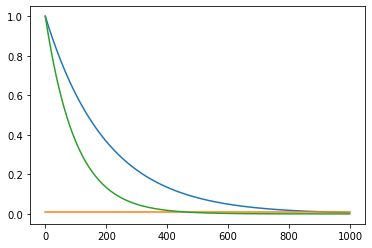

In [574]:
plt.plot(e2)
plt.plot(e3)
plt.plot(e4)

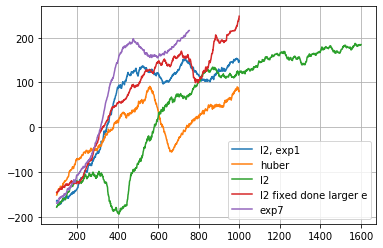

In [554]:
import matplotlib.pyplot as plt
#plt.plot(pd.Series(R_list_exp1))
plt.plot(pd.Series(R_list_exp1).rolling(100).mean(), label='l2, exp1')
plt.plot(pd.Series(R_list_huber).rolling(100).mean(), label='huber')
plt.plot(pd.Series(R_list_l2).rolling(100).mean(), label='l2')
plt.plot(pd.Series(R_list_l2_exp5).rolling(100).mean(), label='l2 fixed done larger e')
plt.plot(pd.Series(R_list_exp7).rolling(100).mean(), label='exp7')
plt.grid()
plt.legend()

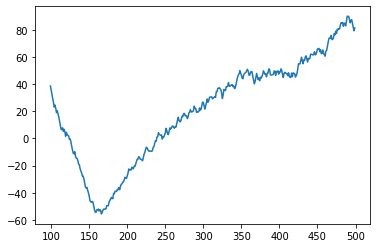

In [346]:
plt.plot(pd.Series(R_list_huber[500:]).rolling(100).mean(), label='huber')

In [552]:
## testing episode for 100
env = gym.make("LunarLander-v2").env
env.seed(5)
test_R_list = []
for i in range(100): 
    
    state = env.reset()
    R = 0
    for t in range(1000): 
        ## get action and excute, get experience tuple
        #env.render()
        y_pred = eval_model(torch.from_numpy(np.array(state)).float()) ## 4 actions
        opt_action = np.argmax(y_pred.detach()).item()
        state_prime, reward, done, info = env.step(opt_action)
        R += reward  
        state=state_prime
        if done:
            break
    print(i, R, t, np.mean(test_R_list[-50:]))
    test_R_list.append(R)
    
#env.close()    

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 215.6106764038205 577 nan
1 91.59184498129414 999 215.6106764038205
2 200.08822977691835 636 153.60126069255733
3 231.32776036404104 467 169.09691705401102
4 171.23615156536624 640 184.6546278815185
5 220.1205354040261 548 181.97093261828803
6 -20.591265914898962 999 188.3291997492444
7 213.57995514073912 556 158.48341894008107
8 224.94514945274398 603 165.3704859651633
9 210.67942971968887 545 171.98989301933892
10 198.86539970266807 611 175.85884668937393
11 -93.03462254865636 999 177.9503515087643
12 239.1794283732482 455 155.36827033731257
13 179.9612931851944 646 161.815282493923
14 203.98524118874352 487 163.11142611472812
15 212.06506170336363 560 165.8363471196625
16 195.64183279655242 596 168.7256417811438
17 -74.21196431284262 999 170.30894713499137
18 228.27469354355787 484 156.72445205455614
19 232.83522174239428 510 160.49025423818782
20 233.95038531638943 465 164.10750261339814
21 231.72152777463793 506 167.43335417068343
22 207.9762115324207 581 170.3555438799541
23 -1

KeyboardInterrupt: 

In [537]:
pd.Series(test_R_list).mean(),pd.Series(test_R_list).std()

(284.6050002291636, 31.013786147875535)

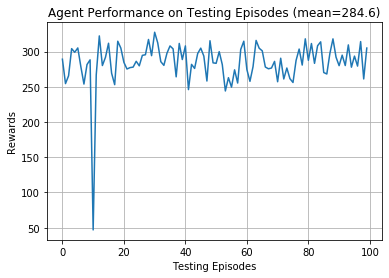

In [539]:
plt.plot(pd.Series(test_R_list))
plt.title('Agent Performance on Testing Episodes (mean=284.6)')
plt.xlabel('Testing Episodes')
plt.ylabel('Rewards')
plt.grid()

In [290]:
np.median(R_list_l2[500:]),np.std(R_list_l2[500:])

(176.01011322716778, 124.28028076440278)

In [412]:
eval_model_exp5 = eval_model
target_model_exp5 = target_model

In [535]:
test_R_list_exp5 = test_R_list

In [410]:
R_list_np.to_csv('R_list.csv')

In [411]:
pd.Series(test_R_list).to_csv('R_list_test.csv')

In [416]:
def save_weights(eval_net,target_net, weight_name="weights", model_name="model"):
    torch.save(eval_net.state_dict(), os.path.join("{}_eval_net".format(weight_name)))
    torch.save(target_net.state_dict(), os.path.join("{}_target_net".format(weight_name)))
    torch.save(eval_net, os.path.join("{}_eval_net".format(model_name)))
    torch.save(target_net, os.path.join("{}_target_net".format(model_name)))


In [417]:
import os
save_weights(eval_model,target_model, weight_name="weights", model_name="exp5")